In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [47]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

In [48]:
train_data.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [49]:
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

Correlation Matrix

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

                    day  pressure   maxtemp  temparature   mintemp  dewpoint  \
day            1.000000  0.005337  0.146294     0.153590  0.161475  0.137929   
pressure       0.005337  1.000000 -0.800499    -0.816531 -0.814453 -0.817008   
maxtemp        0.146294 -0.800499  1.000000     0.982932  0.965529  0.906703   
temparature    0.153590 -0.816531  0.982932     1.000000  0.987150  0.933617   
mintemp        0.161475 -0.814453  0.965529     0.987150  1.000000  0.941342   
dewpoint       0.137929 -0.817008  0.906703     0.933617  0.941342  1.000000   
humidity      -0.074048 -0.119949 -0.072615    -0.025016  0.009891  0.153390   
cloud         -0.048175  0.098600 -0.289047    -0.249355 -0.219399 -0.088446   
sunshine       0.060936 -0.257163  0.452387     0.414019  0.379497  0.249676   
winddirection  0.024800 -0.643293  0.662235     0.668963  0.663828  0.643073   
windspeed     -0.000199  0.266012 -0.354168    -0.342262 -0.328871 -0.312179   
rainfall      -0.000462 -0.049886 -0.079

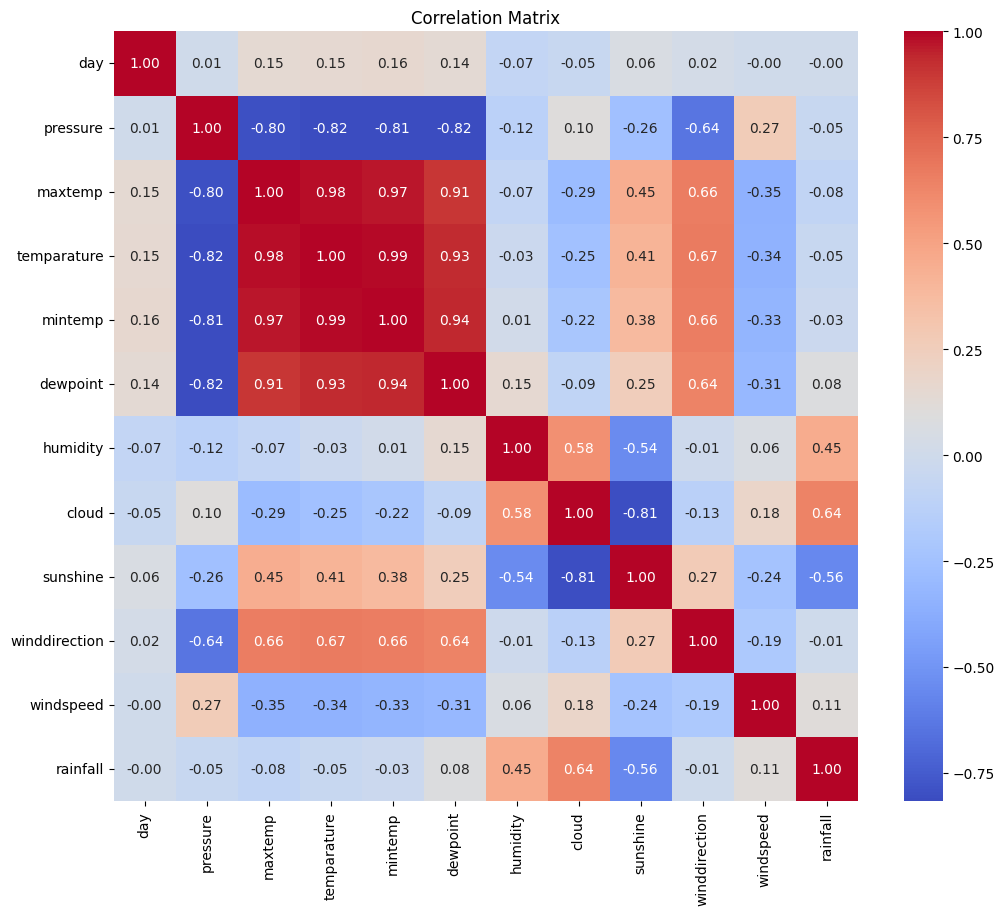

In [51]:
train_data_corr = train_data.drop('id', axis=1)
corr_matrix = train_data_corr.corr()
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Model Creation (LBGM) Baseline

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt

In [53]:
X = train_data_corr.drop(columns=['rainfall'])
y = train_data_corr['rainfall']

In [54]:
#Creating Train and Validtion Data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set model parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

# Train the model with early stopping on the validation set
evals_result = {}
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=51), lgb.log_evaluation(100)],
)

Training until validation scores don't improve for 51 rounds
[100]	train's auc: 0.997371	valid's auc: 0.875561
Early stopping, best iteration is:
[51]	train's auc: 0.979453	valid's auc: 0.881229


Validation ROC AUC Score: 0.8812


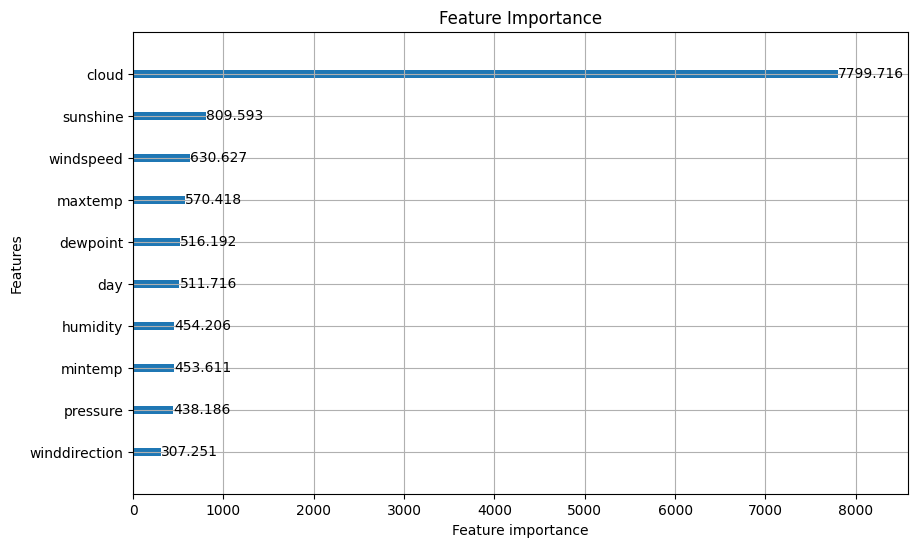

In [56]:
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate and print the ROC AUC score
auc_score = roc_auc_score(y_val, y_pred)
print(f'Validation ROC AUC Score: {auc_score:.4f}')

# Plot feature importance
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

Using Optuna and K-Fold for best parameters

In [57]:
from sklearn.model_selection import KFold
import optuna

def objective(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1,
        'seed': 42
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        # Train with early stopping
        gbm = lgb.train(param,
                        train_data,
                        num_boost_round=10000,
                        valid_sets=[valid_data],
                        callbacks=[lgb.early_stopping(stopping_rounds=51), lgb.log_evaluation(100)])
        
        # Predict and compute ROC AUC for the fold
        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        auc = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc)
    
    # Return the mean AUC over the 5 folds
    return np.mean(auc_scores)


In [58]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial's results
print("Best trial:")
trial = study.best_trial
print(f"  Mean ROC AUC: {trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-31 18:51:59,581] A new study created in memory with name: no-name-80854bb5-bea2-48ea-a731-487d2b6000b0
<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.su

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.86826
[200]	valid_0's auc: 0.866626
Early stopping, best iteration is:
[156]	valid_0's auc: 0.869471
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.885298
Early stopping, best iteration is:
[58]	valid_0's auc: 0.891189
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.910837
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.930591
Early stopping, best iteration is:
[66]	valid_0's auc: 0.933427
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:00,070] Trial 0 finished with value: 0.8982630073362665 and parameters: {'learning_rate': 0.03570533774304722, 'num_leaves': 23, 'max_depth': 9, 'min_data_in_leaf': 48, 'lambda_l1': 1.1612709150327063, 'lambda_l2': 1.5900271397172733e-06, 'feature_fraction': 0.9005752993288954, 'bagging_fraction': 0.7544893451861379, 'bagging_freq': 8}. Best is trial 0 with value: 0.8982630073362665.


[100]	valid_0's auc: 0.885299
Early stopping, best iteration is:
[83]	valid_0's auc: 0.88639
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.868918
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.891468
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.907386
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.93352
Early stopping, best iteration is:
[77]	valid_0's auc: 0.93444
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.876772
Early stopping, best iteration is:
[112]	valid_0's auc: 0.877568
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.868062
Early stopping, best iteration is:
[116]	valid_0's auc: 0.868773
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[22]	valid_0's auc: 0.888654
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.905834
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.931417
Early stopping, best iteration is:
[54]	valid_0's auc: 0.933583
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.877067
Early stopping, best iteration is:
[61]	valid_0's auc: 0.878608
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.867943
Early stopping, best iteration is:
[75]	valid_0's auc: 0.869392
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.899029
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.905876
Early stopping, best iteration is:
[144]	valid_0's auc: 0.9074
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933427
Early stopping, best iteration is:
[70]	valid_0's auc: 0.935079
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:01,275] Trial 3 finished with value: 0.8989264829264743 and parameters: {'learning_rate': 0.001390810701158795, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 29, 'lambda_l1': 1.4176987674043962e-05, 'lambda_l2': 0.00027769465176940346, 'feature_fraction': 0.8792101844658702, 'bagging_fraction': 0.5763878132755119, 'bagging_freq': 5}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.882654
Early stopping, best iteration is:
[79]	valid_0's auc: 0.883732
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.867733
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.890432


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[200]	valid_0's auc: 0.892504
Early stopping, best iteration is:
[176]	valid_0's auc: 0.89337
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906652
Early stopping, best iteration is:
[83]	valid_0's auc: 0.908592
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:01,961] Trial 4 finished with value: 0.8984206971221642 and parameters: {'learning_rate': 0.002735577401141644, 'num_leaves': 108, 'max_depth': 11, 'min_data_in_leaf': 22, 'lambda_l1': 2.960109744759015e-08, 'lambda_l2': 0.13085401300570554, 'feature_fraction': 0.6801657981794764, 'bagging_fraction': 0.6219506164368818, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.932211
Early stopping, best iteration is:
[134]	valid_0's auc: 0.933926
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.888484
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.864348
[200]	valid_0's auc: 0.867746
[300]	valid_0's auc: 0.86876
[400]	valid_0's auc: 0.869656
Early stopping, best iteration is:
[445]	valid_0's auc: 0.869945
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.888885
[200]	valid_0's auc: 0.891715
[300]	valid_0's auc: 0.893029
Early stopping, best iteration is:
[313]	valid_0's auc: 0.893215
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.888248
[200]	valid_0's auc: 0.898877
[300]	valid_0's auc: 0.900554
[400]	valid_0's auc: 0.90122
[500]	valid_0's auc: 0.901441
Early stopping, best iteration is:
[517]	valid_0's auc: 0.901635
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.932055


[I 2025-03-31 18:52:02,878] Trial 5 finished with value: 0.8953738208590287 and parameters: {'learning_rate': 0.0179719958284448, 'num_leaves': 31, 'max_depth': 8, 'min_data_in_leaf': 15, 'lambda_l1': 8.762303600671467, 'lambda_l2': 0.004715861844164242, 'feature_fraction': 0.7189442157348329, 'bagging_fraction': 0.9963915331643194, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[111]	valid_0's auc: 0.932694
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.878339
Early stopping, best iteration is:
[123]	valid_0's auc: 0.879379
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[14]	valid_0's auc: 0.862477
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.886133
Early stopping, best iteration is:
[52]	valid_0's auc: 0.890509
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:03,288] Trial 6 finished with value: 0.895011838498102 and parameters: {'learning_rate': 0.011929803159376045, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 96, 'lambda_l1': 2.0041693360129996e-07, 'lambda_l2': 3.491265061630634e-07, 'feature_fraction': 0.8745541768901608, 'bagging_fraction': 0.8131145669534041, 'bagging_freq': 7}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.909382
Early stopping, best iteration is:
[99]	valid_0's auc: 0.909687
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.936185
Early stopping, best iteration is:
[91]	valid_0's auc: 0.937245
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.875141
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.854825


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[200]	valid_0's auc: 0.864255
[300]	valid_0's auc: 0.869827
[400]	valid_0's auc: 0.871302
[500]	valid_0's auc: 0.872685
Early stopping, best iteration is:
[530]	valid_0's auc: 0.873238
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.881139
Early stopping, best iteration is:
[68]	valid_0's auc: 0.882175
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.891879


[I 2025-03-31 18:52:03,700] Trial 7 finished with value: 0.8905520210561646 and parameters: {'learning_rate': 0.011850081863144388, 'num_leaves': 91, 'max_depth': 3, 'min_data_in_leaf': 54, 'lambda_l1': 9.618998446751945, 'lambda_l2': 0.0002796408048949677, 'feature_fraction': 0.8427321291011722, 'bagging_fraction': 0.5466880260931846, 'bagging_freq': 9}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[146]	valid_0's auc: 0.897159
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.925339
[200]	valid_0's auc: 0.929593
Early stopping, best iteration is:
[172]	valid_0's auc: 0.9307
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.868168
Early stopping, best iteration is:
[82]	valid_0's auc: 0.869594
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.866547


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[92]	valid_0's auc: 0.866982
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.887215
Early stopping, best iteration is:
[56]	valid_0's auc: 0.887849
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[27]	valid_0's auc: 0.90582
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.934549


[I 2025-03-31 18:52:04,087] Trial 8 finished with value: 0.8949474058819199 and parameters: {'learning_rate': 0.001253545172049616, 'num_leaves': 87, 'max_depth': 5, 'min_data_in_leaf': 49, 'lambda_l1': 0.01341818350440028, 'lambda_l2': 2.7699346434801732e-08, 'feature_fraction': 0.7373293783712339, 'bagging_fraction': 0.8138467390321655, 'bagging_freq': 7}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[111]	valid_0's auc: 0.935079
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.879007
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.86955
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.887339
Early stopping, best iteration is:
[62]	valid_0's auc: 0.888143
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.902993
Early stopping, best iteration is:
[49]	valid_0's auc: 0.904961
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.934393


[I 2025-03-31 18:52:04,588] Trial 9 finished with value: 0.8955262374746159 and parameters: {'learning_rate': 0.005127410932803117, 'num_leaves': 88, 'max_depth': 11, 'min_data_in_leaf': 48, 'lambda_l1': 1.5023710428880396e-07, 'lambda_l2': 0.0003328558063489137, 'feature_fraction': 0.7773862865168016, 'bagging_fraction': 0.8677787382918581, 'bagging_freq': 6}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[136]	valid_0's auc: 0.935764
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.879212
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.868022


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[85]	valid_0's auc: 0.869023
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.890942
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.902799
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.935203
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:04,926] Trial 10 finished with value: 0.8951072947465569 and parameters: {'learning_rate': 0.0011155706353164854, 'num_leaves': 131, 'max_depth': 12, 'min_data_in_leaf': 30, 'lambda_l1': 2.48217439172081e-05, 'lambda_l2': 1.937621798994692, 'feature_fraction': 0.6160081771547331, 'bagging_fraction': 0.5099062625512308, 'bagging_freq': 1}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.877568
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.859092
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.884448
Early stopping, best iteration is:
[72]	valid_0's auc: 0.888004
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.88707
Early stopping, best iteration is:
[93]	valid_0's auc: 0.888623
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.921942
[200]	valid_0's auc: 0.926274
Early stopping, best iteration is:
[151]	valid_0's auc: 0.928206
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.872265


[I 2025-03-31 18:52:05,407] Trial 11 finished with value: 0.8877901648058838 and parameters: {'learning_rate': 0.0021626815006883264, 'num_leaves': 125, 'max_depth': 10, 'min_data_in_leaf': 22, 'lambda_l1': 1.790479558100916e-08, 'lambda_l2': 4.169058428355162, 'feature_fraction': 0.9630701606756669, 'bagging_fraction': 0.6110806477861052, 'bagging_freq': 10}. Best is trial 3 with value: 0.8989264829264743.


[200]	valid_0's auc: 0.874512
Early stopping, best iteration is:
[151]	valid_0's auc: 0.875026
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.867496
Early stopping, best iteration is:
[52]	valid_0's auc: 0.869735
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[41]	valid_0's auc: 0.89238
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.912306
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933271
Early stopping, best iteration is:
[58]	valid_0's auc: 0.934331
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:05,851] Trial 12 finished with value: 0.8979240026699202 and parameters: {'learning_rate': 0.002094492284347433, 'num_leaves': 149, 'max_depth': 12, 'min_data_in_leaf': 34, 'lambda_l1': 1.1492259852086855e-05, 'lambda_l2': 0.1328864459922324, 'feature_fraction': 0.6623893512245007, 'bagging_fraction': 0.6546531815987658, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[15]	valid_0's auc: 0.880869
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.871948
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[11]	valid_0's auc: 0.879809
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.898808
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:06,575] Trial 13 finished with value: 0.8906792869860276 and parameters: {'learning_rate': 0.07615329314338956, 'num_leaves': 115, 'max_depth': 10, 'min_data_in_leaf': 11, 'lambda_l1': 4.426404239747593e-05, 'lambda_l2': 0.06647493116377931, 'feature_fraction': 0.9704136949668845, 'bagging_fraction': 0.5790125424644492, 'bagging_freq': 5}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[28]	valid_0's auc: 0.930092
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.866422
Early stopping, best iteration is:
[79]	valid_0's auc: 0.87274


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.869682
Early stopping, best iteration is:
[80]	valid_0's auc: 0.869972
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.896895
Early stopping, best iteration is:
[100]	valid_0's auc: 0.896895
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.908038
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.931588


[I 2025-03-31 18:52:07,216] Trial 14 finished with value: 0.8976319760005991 and parameters: {'learning_rate': 0.005150045413791127, 'num_leaves': 69, 'max_depth': 10, 'min_data_in_leaf': 35, 'lambda_l1': 3.281619313338409e-06, 'lambda_l2': 5.2079550135651864e-05, 'feature_fraction': 0.6540313933478477, 'bagging_fraction': 0.6484637012800406, 'bagging_freq': 2}. Best is trial 3 with value: 0.8989264829264743.


[200]	valid_0's auc: 0.933022
Early stopping, best iteration is:
[184]	valid_0's auc: 0.933427
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.879828
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[48]	valid_0's auc: 0.867706
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.887958
Early stopping, best iteration is:
[50]	valid_0's auc: 0.890478
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.905543
Early stopping, best iteration is:
[82]	valid_0's auc: 0.906846
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.934892


[I 2025-03-31 18:52:07,558] Trial 15 finished with value: 0.8958972275358903 and parameters: {'learning_rate': 0.0010154543954338923, 'num_leaves': 106, 'max_depth': 7, 'min_data_in_leaf': 69, 'lambda_l1': 1.4957386598176123e-08, 'lambda_l2': 0.03728712617796764, 'feature_fraction': 0.5433785248269516, 'bagging_fraction': 0.5046689733678622, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[147]	valid_0's auc: 0.935141
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.879315
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.862859
Early stopping, best iteration is:
[82]	valid_0's auc: 0.865204
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.895086
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.908232
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.928876
Early stopping, best iteration is:
[69]	valid_0's auc: 0.929718
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:09,894] Trial 16 finished with value: 0.8954260757420919 and parameters: {'learning_rate': 0.0024304056076299763, 'num_leaves': 144, 'max_depth': 11, 'min_data_in_leaf': 24, 'lambda_l1': 0.0003032590183223166, 'lambda_l2': 4.594256224450498e-05, 'feature_fraction': 0.902565036538756, 'bagging_fraction': 0.7063453352177415, 'bagging_freq': 10}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.877157
Early stopping, best iteration is:
[57]	valid_0's auc: 0.878891
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.866705
Early stopping, best iteration is:
[144]	valid_0's auc: 0.867917


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.890756
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906292
[200]	valid_0's auc: 0.908176


[I 2025-03-31 18:52:10,416] Trial 17 finished with value: 0.8965949436056503 and parameters: {'learning_rate': 0.0034351293781090552, 'num_leaves': 74, 'max_depth': 7, 'min_data_in_leaf': 40, 'lambda_l1': 0.04027195459316922, 'lambda_l2': 0.002576959562622919, 'feature_fraction': 0.702559493967548, 'bagging_fraction': 0.5985482595957673, 'bagging_freq': 5}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[200]	valid_0's auc: 0.908176
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.935577
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.880548
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.869129
Early stopping, best iteration is:
[107]	valid_0's auc: 0.869234
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.889844
Early stopping, best iteration is:
[50]	valid_0's auc: 0.894699
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.910227


[I 2025-03-31 18:52:10,890] Trial 18 finished with value: 0.8981213875892908 and parameters: {'learning_rate': 0.008331535315595698, 'num_leaves': 106, 'max_depth': 9, 'min_data_in_leaf': 65, 'lambda_l1': 0.0003151431019207229, 'lambda_l2': 0.42755371558007726, 'feature_fraction': 0.7871527591739134, 'bagging_fraction': 0.6543947385295934, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


[200]	valid_0's auc: 0.911696
Early stopping, best iteration is:
[164]	valid_0's auc: 0.913221
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.934144
Early stopping, best iteration is:
[130]	valid_0's auc: 0.934549
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.878904


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.869708
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.884525
Early stopping, best iteration is:
[56]	valid_0's auc: 0.8857
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:11,308] Trial 19 finished with value: 0.8969313552399685 and parameters: {'learning_rate': 0.0016139955321610765, 'num_leaves': 42, 'max_depth': 11, 'min_data_in_leaf': 21, 'lambda_l1': 2.47288144330711e-07, 'lambda_l2': 0.010075142127727324, 'feature_fraction': 0.6030099775109928, 'bagging_fraction': 0.5623298014424207, 'bagging_freq': 7}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[3]	valid_0's auc: 0.911377
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.933676
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.884195
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.864782
Early stopping, best iteration is:
[92]	valid_0's auc: 0.866442
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.888267
Early stopping, best iteration is:
[77]	valid_0's auc: 0.88969
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906125
Early stopping, best iteration is:
[80]	valid_0's auc: 0.907871
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.931401
Early stopping, best iteration is:
[75]	valid_0's auc: 0.933053
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:12,521] Trial 20 finished with value: 0.8953511261131561 and parameters: {'learning_rate': 0.007935783230868982, 'num_leaves': 131, 'max_depth': 9, 'min_data_in_leaf': 10, 'lambda_l1': 2.669400735324234e-06, 'lambda_l2': 0.00020181792070430752, 'feature_fraction': 0.5003421587671788, 'bagging_fraction': 0.7108143327837719, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.87762
Early stopping, best iteration is:
[78]	valid_0's auc: 0.8797
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.86606
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.888669
Early stopping, best iteration is:
[79]	valid_0's auc: 0.894328
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.911807
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:13,093] Trial 21 finished with value: 0.8979522106304196 and parameters: {'learning_rate': 0.03450085432009484, 'num_leaves': 25, 'max_depth': 9, 'min_data_in_leaf': 43, 'lambda_l1': 0.16580276019758547, 'lambda_l2': 6.595057353168417e-07, 'feature_fraction': 0.9258523378177242, 'bagging_fraction': 0.7687260530771849, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.927692
Early stopping, best iteration is:
[51]	valid_0's auc: 0.934424
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.883142


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.865915
Early stopping, best iteration is:
[122]	valid_0's auc: 0.86768
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.892009
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.903686
Early stopping, best iteration is:
[81]	valid_0's auc: 0.907899
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:13,784] Trial 22 finished with value: 0.8959130646686109 and parameters: {'learning_rate': 0.029575222749159122, 'num_leaves': 46, 'max_depth': 10, 'min_data_in_leaf': 29, 'lambda_l1': 0.7347076083150365, 'lambda_l2': 5.592212211113358e-06, 'feature_fraction': 0.9966938048863095, 'bagging_fraction': 0.7601221001277891, 'bagging_freq': 9}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.928502
Early stopping, best iteration is:
[68]	valid_0's auc: 0.929375
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.880496
Early stopping, best iteration is:
[81]	valid_0's auc: 0.882602


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.863004
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.881185
Early stopping, best iteration is:
[59]	valid_0's auc: 0.889164
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:14,229] Trial 23 finished with value: 0.8965628362355712 and parameters: {'learning_rate': 0.048962600909821186, 'num_leaves': 98, 'max_depth': 11, 'min_data_in_leaf': 56, 'lambda_l1': 0.0035822018940393956, 'lambda_l2': 1.218509775233879e-08, 'feature_fraction': 0.8451634572894197, 'bagging_fraction': 0.931052317126367, 'bagging_freq': 9}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[15]	valid_0's auc: 0.907123
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.937556
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.882012
Early stopping, best iteration is:
[72]	valid_0's auc: 0.885967


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.868944
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.887633
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906804
Early stopping, best iteration is:
[61]	valid_0's auc: 0.908121
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:14,601] Trial 24 finished with value: 0.8961918670673343 and parameters: {'learning_rate': 0.019362223279189558, 'num_leaves': 122, 'max_depth': 8, 'min_data_in_leaf': 82, 'lambda_l1': 7.830573174140953e-05, 'lambda_l2': 6.838861352729869e-06, 'feature_fraction': 0.9026339835491839, 'bagging_fraction': 0.6197132281986572, 'bagging_freq': 6}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.932959
Early stopping, best iteration is:
[78]	valid_0's auc: 0.933505
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.882268
Early stopping, best iteration is:
[97]	valid_0's auc: 0.882756
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.86033
Early stopping, best iteration is:
[50]	valid_0's auc: 0.867259
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.895272
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.913858
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:15,020] Trial 25 finished with value: 0.8975101689747644 and parameters: {'learning_rate': 0.08582133714266948, 'num_leaves': 80, 'max_depth': 12, 'min_data_in_leaf': 38, 'lambda_l1': 1.165277245058074, 'lambda_l2': 1.6293646019832967e-07, 'feature_fraction': 0.8409100210700474, 'bagging_fraction': 0.6884568256194081, 'bagging_freq': 7}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[30]	valid_0's auc: 0.930949
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.880214
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[33]	valid_0's auc: 0.861806
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.883721
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.903783
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.929656
Early stopping, best iteration is:
[70]	valid_0's auc: 0.931775
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.882371
Early stopping, best iteration is:
[124]	valid_0's auc: 0.883527


[I 2025-03-31 18:52:15,628] Trial 26 finished with value: 0.8929223025757296 and parameters: {'learning_rate': 0.00155280425517253, 'num_leaves': 114, 'max_depth': 9, 'min_data_in_leaf': 19, 'lambda_l1': 0.0016303846404593565, 'lambda_l2': 2.8947963726946783e-05, 'feature_fraction': 0.9366807129852722, 'bagging_fraction': 0.5470389064296196, 'bagging_freq': 5}. Best is trial 3 with value: 0.8989264829264743.
<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_log

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.867232
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.891112
Early stopping, best iteration is:
[60]	valid_0's auc: 0.89739
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.905571
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.928253
Early stopping, best iteration is:
[64]	valid_0's auc: 0.932055
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:16,216] Trial 27 finished with value: 0.8972218381711716 and parameters: {'learning_rate': 0.01892743526308793, 'num_leaves': 94, 'max_depth': 7, 'min_data_in_leaf': 28, 'lambda_l1': 4.575028159551758e-06, 'lambda_l2': 0.0010462389117568355, 'feature_fraction': 0.6896022434221113, 'bagging_fraction': 0.7346189461060486, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.882782
Early stopping, best iteration is:
[118]	valid_0's auc: 0.883861
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.867772
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.88468
Early stopping, best iteration is:
[79]	valid_0's auc: 0.891236
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.908398
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.926383
Early stopping, best iteration is:
[61]	valid_0's auc: 0.930933
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:16,609] Trial 28 finished with value: 0.8970333049868401 and parameters: {'learning_rate': 0.04574697552163942, 'num_leaves': 67, 'max_depth': 6, 'min_data_in_leaf': 48, 'lambda_l1': 8.69661200286979e-08, 'lambda_l2': 1.0570103648826439, 'feature_fraction': 0.7784669671022892, 'bagging_fraction': 0.7850797502498331, 'bagging_freq': 9}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[33]	valid_0's auc: 0.886827
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.867245
Early stopping, best iteration is:
[86]	valid_0's auc: 0.867417
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[40]	valid_0's auc: 0.887849
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.904545
Early stopping, best iteration is:
[66]	valid_0's auc: 0.907275
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933209
Early stopping, best iteration is:
[103]	valid_0's auc: 0.933536
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:17,053] Trial 29 finished with value: 0.8949243423415207 and parameters: {'learning_rate': 0.003089588775857503, 'num_leaves': 49, 'max_depth': 8, 'min_data_in_leaf': 60, 'lambda_l1': 0.002384188598675247, 'lambda_l2': 1.822951856282934e-06, 'feature_fraction': 0.8720644158737015, 'bagging_fraction': 0.683126513027263, 'bagging_freq': 6}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[24]	valid_0's auc: 0.878544
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.870867
Early stopping, best iteration is:
[114]	valid_0's auc: 0.871526
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[23]	valid_0's auc: 0.89139
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.91056
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.932492
Early stopping, best iteration is:
[76]	valid_0's auc: 0.933988
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:17,559] Trial 30 finished with value: 0.8970989533531597 and parameters: {'learning_rate': 0.003679889779533778, 'num_leaves': 80, 'max_depth': 10, 'min_data_in_leaf': 44, 'lambda_l1': 0.03187218052696501, 'lambda_l2': 7.12003800764258e-08, 'feature_fraction': 0.6078265775398197, 'bagging_fraction': 0.6260948919254592, 'bagging_freq': 3}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.876207
Early stopping, best iteration is:
[112]	valid_0's auc: 0.878031
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.868931
Early stopping, best iteration is:
[98]	valid_0's auc: 0.869063
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.887525
Early stopping, best iteration is:
[50]	valid_0's auc: 0.893679
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.909243
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.935297
Early stopping, best iteration is:
[128]	valid_0's auc: 0.935609
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:17,967] Trial 31 finished with value: 0.8973996819073969 and parameters: {'learning_rate': 0.007767566754727697, 'num_leaves': 103, 'max_depth': 9, 'min_data_in_leaf': 65, 'lambda_l1': 0.00017786870673989545, 'lambda_l2': 0.3049785521883095, 'feature_fraction': 0.7772503603522409, 'bagging_fraction': 0.6671256475933389, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[16]	valid_0's auc: 0.879405
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.86303
[200]	valid_0's auc: 0.866429
[300]	valid_0's auc: 0.86822


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[321]	valid_0's auc: 0.868694
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.882376
[200]	valid_0's auc: 0.885793
Early stopping, best iteration is:
[189]	valid_0's auc: 0.886566
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.899058
[200]	valid_0's auc: 0.903409


[I 2025-03-31 18:52:18,538] Trial 32 finished with value: 0.8935303195995685 and parameters: {'learning_rate': 0.007672705361492627, 'num_leaves': 110, 'max_depth': 9, 'min_data_in_leaf': 81, 'lambda_l1': 0.0004062050819090372, 'lambda_l2': 8.408495495313174, 'feature_fraction': 0.8148671937070716, 'bagging_fraction': 0.7326414863513845, 'bagging_freq': 7}. Best is trial 3 with value: 0.8989264829264743.


[300]	valid_0's auc: 0.906929
Early stopping, best iteration is:
[293]	valid_0's auc: 0.9074
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.928908
[200]	valid_0's auc: 0.930435
Early stopping, best iteration is:
[164]	valid_0's auc: 0.931417
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.873575


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.869326
Early stopping, best iteration is:
[101]	valid_0's auc: 0.869379
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.888143
Early stopping, best iteration is:
[61]	valid_0's auc: 0.89071
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906693
Early stopping, best iteration is:
[103]	valid_0's auc: 0.907414


[I 2025-03-31 18:52:18,940] Trial 33 finished with value: 0.8958879490161952 and parameters: {'learning_rate': 0.001518386925546338, 'num_leaves': 101, 'max_depth': 11, 'min_data_in_leaf': 80, 'lambda_l1': 0.0009134529953381027, 'lambda_l2': 0.023765065401634564, 'feature_fraction': 0.799591344347106, 'bagging_fraction': 0.586305036835397, 'bagging_freq': 8}. Best is trial 3 with value: 0.8989264829264743.


Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933442
Early stopping, best iteration is:
[143]	valid_0's auc: 0.934471
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.877466
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.864795
Early stopping, best iteration is:
[78]	valid_0's auc: 0.865507
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.890323
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.908689
[200]	valid_0's auc: 0.910643
Early stopping, best iteration is:
[174]	valid_0's auc: 0.911558


[I 2025-03-31 18:52:19,432] Trial 34 finished with value: 0.8957821634437677 and parameters: {'learning_rate': 0.013543188078590118, 'num_leaves': 118, 'max_depth': 8, 'min_data_in_leaf': 63, 'lambda_l1': 6.360003104593631e-07, 'lambda_l2': 0.4076842080735385, 'feature_fraction': 0.8803485600521964, 'bagging_fraction': 0.6256301270921392, 'bagging_freq': 6}. Best is trial 3 with value: 0.8989264829264743.


Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933396
Early stopping, best iteration is:
[147]	valid_0's auc: 0.934237
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.877286


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.862569
Early stopping, best iteration is:
[80]	valid_0's auc: 0.865335
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.890478
Early stopping, best iteration is:
[91]	valid_0's auc: 0.891282
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.909562


[I 2025-03-31 18:52:19,837] Trial 35 finished with value: 0.8964043821095741 and parameters: {'learning_rate': 0.006000147919124526, 'num_leaves': 35, 'max_depth': 10, 'min_data_in_leaf': 75, 'lambda_l1': 1.2845114391808402e-05, 'lambda_l2': 0.012337232485313683, 'feature_fraction': 0.7497663544407883, 'bagging_fraction': 0.5334629358306537, 'bagging_freq': 10}. Best is trial 3 with value: 0.8989264829264743.


[200]	valid_0's auc: 0.910698
Early stopping, best iteration is:
[179]	valid_0's auc: 0.911086
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.936871
Early stopping, best iteration is:
[96]	valid_0's auc: 0.937276
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.877042
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.866192
Early stopping, best iteration is:
[75]	valid_0's auc: 0.867535
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.892133
Early stopping, best iteration is:
[87]	valid_0's auc: 0.894668
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.909354
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:20,281] Trial 36 finished with value: 0.8980118963066619 and parameters: {'learning_rate': 0.0271405938511879, 'num_leaves': 138, 'max_depth': 9, 'min_data_in_leaf': 89, 'lambda_l1': 4.158130766572733e-08, 'lambda_l2': 0.0015635890136314562, 'feature_fraction': 0.7201860398053513, 'bagging_fraction': 0.811940911379864, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[43]	valid_0's auc: 0.936824
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.87952
Early stopping, best iteration is:
[132]	valid_0's auc: 0.881678
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[12]	valid_0's auc: 0.866034
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.88318
Early stopping, best iteration is:
[50]	valid_0's auc: 0.887092
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.899501
Early stopping, best iteration is:
[72]	valid_0's auc: 0.90115
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.929936
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.876002
Early stopping, best iteration is:
[65]	valid_0's auc: 0.876772


[I 2025-03-31 18:52:20,828] Trial 37 finished with value: 0.8921967629686913 and parameters: {'learning_rate': 0.004204190795191591, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 17, 'lambda_l1': 0.009368236171394907, 'lambda_l2': 0.5717655182804845, 'feature_fraction': 0.8274735444960293, 'bagging_fraction': 0.8683918644710727, 'bagging_freq': 9}. Best is trial 3 with value: 0.8989264829264743.


Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.867917
Early stopping, best iteration is:
[89]	valid_0's auc: 0.869366
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.885948
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.902453
Early stopping, best iteration is:
[72]	valid_0's auc: 0.904282
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.930404
[200]	valid_0's auc: 0.931541
[300]	valid_0's auc: 0.932461
Early stopping, best iteration is:
[317]	valid_0's auc: 0.932803
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.874486


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.862438
Early stopping, best iteration is:
[106]	valid_0's auc: 0.863096
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.885422
Early stopping, best iteration is:
[52]	valid_0's auc: 0.887154
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.903395
Early stopping, best iteration is:
[62]	valid_0's auc: 0.90467
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:21,662] Trial 39 finished with value: 0.8910030702700921 and parameters: {'learning_rate': 0.0017959592567153627, 'num_leaves': 95, 'max_depth': 11, 'min_data_in_leaf': 99, 'lambda_l1': 1.1894627571160102e-06, 'lambda_l2': 0.0004893166281469563, 'feature_fraction': 0.9267532370125283, 'bagging_fraction': 0.6687158862447835, 'bagging_freq': 3}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.929921
[200]	valid_0's auc: 0.931276
[300]	valid_0's auc: 0.931806
Early stopping, best iteration is:
[288]	valid_0's auc: 0.932274
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.867822


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.858381
[200]	valid_0's auc: 0.862569
[300]	valid_0's auc: 0.863044
Early stopping, best iteration is:
[268]	valid_0's auc: 0.864519
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.884633
[200]	valid_0's auc: 0.885298
Early stopping, best iteration is:
[156]	valid_0's auc: 0.887293
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.898101
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.933022
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.873793
[200]	valid_0's auc: 0.876824
[300]	valid_0's auc: 0.880753
Early stopping, best iteration is:
[303]	valid_0's auc: 0.88101


[I 2025-03-31 18:52:22,893] Trial 40 finished with value: 0.892788922735544 and parameters: {'learning_rate': 0.0103294133054517, 'num_leaves': 83, 'max_depth': 12, 'min_data_in_leaf': 33, 'lambda_l1': 0.3573157209294442, 'lambda_l2': 0.0061355644293931266, 'feature_fraction': 0.7864142009097403, 'bagging_fraction': 0.9936938273197, 'bagging_freq': 5}. Best is trial 3 with value: 0.8989264829264743.
<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('

Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.869221
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.891066
Early stopping, best iteration is:
[89]	valid_0's auc: 0.892055
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906652
[200]	valid_0's auc: 0.907899
Early stopping, best iteration is:
[192]	valid_0's auc: 0.908758
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:23,482] Trial 41 finished with value: 0.8975714023416625 and parameters: {'learning_rate': 0.02605147368600139, 'num_leaves': 142, 'max_depth': 9, 'min_data_in_leaf': 91, 'lambda_l1': 3.3115523070335744e-08, 'lambda_l2': 0.0018521164157886602, 'feature_fraction': 0.7312412865904693, 'bagging_fraction': 0.8364706377471968, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


[100]	valid_0's auc: 0.932336
Early stopping, best iteration is:
[52]	valid_0's auc: 0.936247
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.880214
Early stopping, best iteration is:
[113]	valid_0's auc: 0.881575
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.86934
Early stopping, best iteration is:
[76]	valid_0's auc: 0.869893
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.889767
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.909313
Early stopping, best iteration is:
[74]	valid_0's auc: 0.911142
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.935562


[I 2025-03-31 18:52:23,854] Trial 42 finished with value: 0.8975927758459024 and parameters: {'learning_rate': 0.06049194421615108, 'num_leaves': 133, 'max_depth': 10, 'min_data_in_leaf': 86, 'lambda_l1': 4.050307804808964e-08, 'lambda_l2': 2.2184440301976367, 'feature_fraction': 0.6559463802138085, 'bagging_fraction': 0.8028537964263867, 'bagging_freq': 4}. Best is trial 3 with value: 0.8989264829264743.


Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.878442
Early stopping, best iteration is:
[65]	valid_0's auc: 0.881601
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.871091
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

[100]	valid_0's auc: 0.88802
Early stopping, best iteration is:
[115]	valid_0's auc: 0.889318
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.906818
Early stopping, best iteration is:
[105]	valid_0's auc: 0.907788
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:24,323] Trial 43 finished with value: 0.8963137966481176 and parameters: {'learning_rate': 0.014121129751417, 'num_leaves': 109, 'max_depth': 8, 'min_data_in_leaf': 73, 'lambda_l1': 2.6580897219536725e-07, 'lambda_l2': 2.2107182036129714e-05, 'feature_fraction': 0.7059356224609341, 'bagging_fraction': 0.8897063001826847, 'bagging_freq': 3}. Best is trial 3 with value: 0.8989264829264743.


Early stopping, best iteration is:
[38]	valid_0's auc: 0.936201
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.87717
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.865098
Early stopping, best iteration is:
[75]	valid_0's auc: 0.866824


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.892968
Early stopping, best iteration is:
[121]	valid_0's auc: 0.895905
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.909673
[200]	valid_0's auc: 0.911225
Early stopping, best iteration is:
[214]	valid_0's auc: 0.912611
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.933614
Early stopping, best iteration is:
[74]	valid_0's auc: 0.93698
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.880907
[200]	valid_0's auc: 0.882448


[I 2025-03-31 18:52:24,912] Trial 44 finished with value: 0.8991591093273223 and parameters: {'learning_rate': 0.023254124517158827, 'num_leaves': 125, 'max_depth': 9, 'min_data_in_leaf': 93, 'lambda_l1': 1.219568335051858e-08, 'lambda_l2': 0.00010377492151114272, 'feature_fraction': 0.756848061020119, 'bagging_fraction': 0.7812420961101042, 'bagging_freq': 2}. Best is trial 44 with value: 0.8991591093273223.


Early stopping, best iteration is:
[176]	valid_0's auc: 0.883475
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.869419
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.893153
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[9]	valid_0's auc: 0.905959
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.935406
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.881832
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[15]	valid_0's auc: 0.863175
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.887154
Early stopping, best iteration is:
[76]	valid_0's auc: 0.88836
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:25,814] Trial 46 finished with value: 0.8940255723523023 and parameters: {'learning_rate': 0.03426651999610699, 'num_leaves': 112, 'max_depth': 9, 'min_data_in_leaf': 25, 'lambda_l1': 9.83951664686896e-08, 'lambda_l2': 1.1276473535990807e-06, 'feature_fraction': 0.6843746475948231, 'bagging_fraction': 0.7774251298496712, 'bagging_freq': 2}. Best is trial 44 with value: 0.8991591093273223.


Early stopping, best iteration is:
[38]	valid_0's auc: 0.907206
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.932367
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.879019


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.86826
[200]	valid_0's auc: 0.870077
Early stopping, best iteration is:
[164]	valid_0's auc: 0.871184
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.885886
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.904227
[200]	valid_0's auc: 0.906735
[300]	valid_0's auc: 0.908426
[400]	valid_0's auc: 0.912417
Early stopping, best iteration is:
[401]	valid_0's auc: 0.912722
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.932165
Early stopping, best iteration is:
[91]	valid_0's auc: 0.933162
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:26,357] Trial 47 finished with value: 0.8965049062282052 and parameters: {'learning_rate': 0.021972845390527455, 'num_leaves': 89, 'max_depth': 10, 'min_data_in_leaf': 94, 'lambda_l1': 2.343247293196258, 'lambda_l2': 0.0005880036808174071, 'feature_fraction': 0.8909738235922793, 'bagging_fraction': 0.5693839676385263, 'bagging_freq': 2}. Best is trial 44 with value: 0.8991591093273223.


[100]	valid_0's auc: 0.874949
[200]	valid_0's auc: 0.879289
Early stopping, best iteration is:
[194]	valid_0's auc: 0.879572
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.871658


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.886133
[200]	valid_0's auc: 0.888607
Early stopping, best iteration is:
[166]	valid_0's auc: 0.889473
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.911336
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:27,188] Trial 48 finished with value: 0.8988535947363354 and parameters: {'learning_rate': 0.014562393490237656, 'num_leaves': 121, 'max_depth': 11, 'min_data_in_leaf': 16, 'lambda_l1': 7.998774748778016e-07, 'lambda_l2': 1.3348664071217313e-05, 'feature_fraction': 0.6415051432140367, 'bagging_fraction': 0.7130903943965471, 'bagging_freq': 7}. Best is trial 44 with value: 0.8991591093273223.


Early stopping, best iteration is:
[19]	valid_0's auc: 0.929157
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.892644
Training until validation scores don't improve for 51 rounds


<ipython-input-57-163b7f9c40ab>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-57-163b7f9c40ab>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-57-163b7f9c40ab>:16: FutureWarning: suggest_uniform has 

Early stopping, best iteration is:
[4]	valid_0's auc: 0.863505
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.887494
Early stopping, best iteration is:
[56]	valid_0's auc: 0.894854
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[27]	valid_0's auc: 0.908869
Training until validation scores don't improve for 51 rounds


[I 2025-03-31 18:52:27,996] Trial 49 finished with value: 0.8948889269379462 and parameters: {'learning_rate': 0.04129045217945418, 'num_leaves': 121, 'max_depth': 12, 'min_data_in_leaf': 14, 'lambda_l1': 8.943069019532843e-07, 'lambda_l2': 1.2171302996869127e-05, 'feature_fraction': 0.6295154534396508, 'bagging_fraction': 0.7169243325696435, 'bagging_freq': 7}. Best is trial 44 with value: 0.8991591093273223.


[100]	valid_0's auc: 0.920274
Early stopping, best iteration is:
[50]	valid_0's auc: 0.923484
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883732
Best trial:
  Mean ROC AUC: 0.8992
  Best hyperparameters:
    learning_rate: 0.023254124517158827
    num_leaves: 125
    max_depth: 9
    min_data_in_leaf: 93
    lambda_l1: 1.219568335051858e-08
    lambda_l2: 0.00010377492151114272
    feature_fraction: 0.756848061020119
    bagging_fraction: 0.7812420961101042
    bagging_freq: 2


Final Model

In [59]:
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.065454527499469,
    'num_leaves': 113,
    'max_depth': 8,
    'min_data_in_leaf': 73,
    'lambda_l1': 1.2122473288279279,
    'lambda_l2': 0.0010871552313985935,
    'feature_fraction': 0.7697601416505045,
    'bagging_fraction': 0.6694372455582107,
    'bagging_freq': 2,
    'verbose': -1,
    'seed': 42
}

# 5-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X.shape[0])
fold_auc_scores = []


In [60]:
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=10000,  # A high number; early stopping will decide when to stop
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=51), lgb.log_evaluation(100)]
    )
    
    # Predict on validation fold and calculate ROC AUC
    oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    fold_auc = roc_auc_score(y_valid, oof_preds[valid_idx])
    fold_auc_scores.append(fold_auc)
    print(f"Fold {fold+1} ROC AUC: {fold_auc:.4f}")

mean_auc = np.mean(fold_auc_scores)
print(f"Mean ROC AUC across folds: {mean_auc:.4f}")


Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.869682
Early stopping, best iteration is:
[77]	valid_0's auc: 0.872211
Fold 1 ROC AUC: 0.8722
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.882453
Early stopping, best iteration is:
[51]	valid_0's auc: 0.891452
Fold 2 ROC AUC: 0.8915
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.914634
Early stopping, best iteration is:
[85]	valid_0's auc: 0.917655
Fold 3 ROC AUC: 0.9177
Training until validation scores don't improve for 51 rounds
[100]	valid_0's auc: 0.928004
Early stopping, best iteration is:
[52]	valid_0's auc: 0.936357
Fold 4 ROC AUC: 0.9364
Training until validation scores don't improve for 51 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.884888
Fold 5 ROC AUC: 0.8849
Mean ROC AUC across folds: 0.9005


In [61]:
final_train_data = lgb.Dataset(X, label=y)
final_model = lgb.train(
    best_params,
    final_train_data,
    num_boost_round=int(np.mean([model.best_iteration for _ in range(1)]))  # You can also set a fixed number
)


Submission

In [62]:
X_test = test_data.drop(["id"], axis = 1)
X_test.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')

In [63]:
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)

In [64]:
submission = pd.DataFrame({
    'id': test_data['id'],           
    'rainfall': test_preds          
})

# 5. Save to CSV
submission.to_csv('submission.csv', index=False)

In [65]:
submission.head()

,id,rainfall
0,2190,0.958515
1,2191,0.961920
2,2192,0.891696
3,2193,0.187968
4,2194,0.151836
